## Run analysis on manual line ROIs to measure first/second/third order branches

Requires a roi.zip file and analysis.csv

In [1]:
%load_ext autoreload
%autoreload 2

import os, math, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

from IPython.display import display # to prettyprint pandas table

import sanode

#import bReadROI # in notebooks folder


In [2]:
def defaultSeabornLayout(plotForTalk=False):
    if plotForTalk:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    fontSize = 10
    if plotForTalk: fontSize = 14

    mpl.rcParams['figure.figsize'] = [4.0, 4.0]
    mpl.rcParams['lines.linewidth'] = 1.0
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.labelsize'] = fontSize # font size of x/y axes labels (not ticks)
    mpl.rcParams['xtick.labelsize']=fontSize
    mpl.rcParams['ytick.labelsize']=fontSize

#
defaultSeabornLayout(plotForTalk=False)


In [3]:
# utilities

def getSortedGroups(groupList):
    """
    Given [1, 2, 3, 11], return [1, 11, 2, 3]
    
    return: list of int
    """
    
    strList = [str(s) for s in groupList] # convert to list of str
    sortedIdx = [strList.index(x) for x in sorted(strList)] # sort the list of str
    theRet = [groupList[idx] for idx in sortedIdx] # return groups (int) sorted in str order
    return theRet

# match each group (int) to a color
palletteDict = {
    0: 'y',
    1: 'r',
    11: '#cc1100',
    2: 'g',
    3: 'b',
    4: 'c',
    5: 'm',
    6: 'y'
}
def getGroupPallete(groupList):
    """
    Given a list of groups like, [1, 11, 2, 3]
    Return a list of colors (using palletteDict)
    """
    colorList = [''] * len(groupList)
    for idx, group in enumerate(groupList):
        colorList[idx] = palletteDict[group]
    return colorList
    

## reworking to make load given original .tif

- dropping dependency of results .csv
- reading voxel size from original tif


In [4]:
def loadRoiFiles(path):
    """
    path: full path to original .tif
    load MAX_
    load df from Fiji Roi Manager RoiSet.zip
    return df, maxImg
    """
    print('loadRoiFile() path:', path)
    
    # get voxel size
    x, y, z, shape = sanode.bTiffFile.readVoxelSize(path, getShape=True)
    print('  shape:', shape)
    print('  x/y/z voxel (um/pixel)', x,y,z)
    xyzVoxel = (x,y,z)

    origPath, origTiff = os.path.split(path)

    # load the max
    maxPath = os.path.join(origPath, 'MAX_' + origTiff)
    maxImg = plt.imread(maxPath)

    # load roi .zip
    tmpPath, tmpFile = os.path.split(path)
    zipFilePath = os.path.join(tmpPath, 'RoiSet.zip')
    print('  loading zipFilePath:', zipFilePath)
    df = sanode.bReadROI.loadRoiZip2(zipFilePath, xyzVoxel)

    return df, maxImg


In [184]:
if 1:
    # san3 headMid is working well
    path = '/media/cudmore/data/san-density/SAN3/tracing/head/SAN3_head_BIG__ch2.tif'
    dfHeadMid, dfHeadMid_maxImg = loadRoiFiles(path)
    dfHeadMid['origRegions'] = 'headMid'
    # display stats for each group (this is across entire image including superior/inferior
    desc = dfHeadMid.groupby('group')['length_um'].describe()
    display(desc)

    # san3 tail
    path = '/media/cudmore/data/san-density/SAN3/tracing/tail/SAN3_tail_BIG__ch2.tif'
    dfTail, dfTail_maxImg = loadRoiFiles(path)
    dfTail['origRegions'] = 'tail'
    # display stats for each group (this is across entire image including superior/inferior
    desc = dfTail.groupby('group')['length_um'].describe()
    display(desc)

    # tmp
    df = dfHeadMid
    maxImg = dfHeadMid_maxImg
    #df = dfTail
    #maxImg = dfTail_maxImg

    # merge headMid and tail
    # dfFinal = dfHeadMid + dfTail

    ##
    # put this back in
    ##
    #
    groupList = df['group'].unique()
    sortedGroups = getSortedGroups(groupList)
    sortedPallette = getGroupPallete(sortedGroups)

    print('groupList:', groupList)
    print('sortedGroups:', sortedGroups)
    print('sortedPallette:', sortedPallette)


loadRoiFile() path: /media/cudmore/data/san-density/SAN3/tracing/head/SAN3_head_BIG__ch2.tif
  shape: (83, 2370, 5214)
  x/y/z voxel (um/pixel) 0.6214808646041788 0.6214808646041788 1
  loading zipFilePath: /media/cudmore/data/san-density/SAN3/tracing/head/RoiSet.zip


count       mean       std       min        25%        50%        75%  \
group                                                                          
0        3.0   7.047081  2.294825  4.733057   5.909515   7.085972   8.204093   
1       69.0  25.079199  3.993246  3.623825  23.003189  25.488293  27.345158   
2       95.0  11.592212  2.336530  4.481562  10.417918  11.824480  12.812156   
3      129.0   7.230990  2.346401  2.779347   5.558694   7.031253   8.722900   
4      112.0   5.160655  1.900712  1.757813   3.728885   4.628753   6.750830   

             max  
group             
0       9.322213  
1      33.812215  
2      17.267776  
3      15.586661  
4      10.193044

loadRoiFile() path: /media/cudmore/data/san-density/SAN3/tracing/tail/SAN3_tail_BIG__ch2.tif
  shape: (77, 2844, 2844)
  x/y/z voxel (um/pixel) 0.6214808646041788 0.6214808646041788 1
  loading zipFilePath: /media/cudmore/data/san-density/SAN3/tracing/tail/RoiSet.zip


count       mean       std        min        25%        50%        75%  \
group                                                                           
0        2.0   5.956151  1.010237   5.241806   5.598978   5.956151   6.313324   
1       95.0  28.348627  5.985817  10.583438  24.146758  27.935956  32.998766   
2      102.0  10.888943  2.520322   5.983771   8.886155  10.972114  12.905926   
3       92.0   7.340672  1.362000   4.353140   6.304750   7.092353   8.384954   
4       93.0   4.366716  1.329226   1.686411   3.212681   4.519277   5.273966   

             max  
group             
0       6.670497  
1      41.120147  
2      16.288142  
3      10.603946  
4       7.415216

groupList: [1 2 3 0 4]
sortedGroups: [0, 1, 2, 3, 4]
sortedPallette: ['y', 'r', 'g', 'b', 'c']


In [171]:
if 1:
    #
    # merge san4 headMid with SAN4 tail

    # san4 headMid is working well
    path = '/media/cudmore/data/san-density/SAN4/tracing/head/SAN4_head_BIG__ch2.tif'
    dfHeadMid, dfHeadMid_maxImg = loadRoiFiles(path)
    dfHeadMid['origRegions'] = 'headMid'

    # san4 tail
    path = '/media/cudmore/data/san-density/SAN4/tracing/tail/SAN4_tail_BIG__ch2.tif'
    dfTail, dfTail_maxImg = loadRoiFiles(path)
    dfTail['origRegions'] = 'tail'

    # tmp
    #df = dfHeadMid
    #maxImg = dfHeadMid_maxImg
    df = dfTail
    maxImg = dfTail_maxImg

    # merge headMid and tail
    # dfFinal = dfHeadMid + dfTail

    groupList = df['group'].unique()
    sortedGroups = getSortedGroups(groupList)
    sortedPallette = getGroupPallete(sortedGroups)

    print('groupList:', groupList)
    print('sortedGroups:', sortedGroups)
    print('sortedPallette:', sortedPallette)


loadRoiFile() path: /media/cudmore/data/san-density/SAN4/tracing/head/SAN4_head_BIG__ch2.tif
  shape: (104, 3552, 7104)
  x/y/z voxel (um/pixel) 0.49718469168334306 0.49718469168334306 1
  loading zipFilePath: /media/cudmore/data/san-density/SAN4/tracing/head/RoiSet.zip
loadRoiFile() path: /media/cudmore/data/san-density/SAN4/tracing/tail/SAN4_tail_BIG__ch2.tif
  shape: (86, 3552, 8288)
  x/y/z voxel (um/pixel) 0.49718469168334306 0.49718469168334306 1
  loading zipFilePath: /media/cudmore/data/san-density/SAN4/tracing/tail/RoiSet.zip
groupList: [1 2 0 3 4]
sortedGroups: [0, 1, 2, 3, 4]
sortedPallette: ['y', 'r', 'g', 'b', 'c']


In [5]:
if 1:
    # san5 (lectin)
    path = '/media/cudmore/data/san-density/SAN5/tracing/SAN5_BIG__ch1.tif'
    
    # san6 (lectin)
    #path = '/media/cudmore/data/san-density/SAN6/tracing/SAN6_BIG__ch1.tif'
 
    df, maxImg = loadRoiFiles(path)
    df['origRegions'] = 'headMidTail'
    # display stats for each group (this is across entire image including superior/inferior
    #desc = df.groupby('group')['length_um'].describe()
    #display(desc)

    groupList = df['group'].unique()
    sortedGroups = getSortedGroups(groupList)
    sortedPallette = getGroupPallete(sortedGroups)

    print('groupList:', groupList)
    print('sortedGroups:', sortedGroups)
    print('sortedPallette:', sortedPallette)
  

loadRoiFile() path: /media/cudmore/data/san-density/SAN5/tracing/SAN5_BIG__ch1.tif
  shape: (109, 2960, 6660)
  x/y/z voxel (um/pixel) 0.3977476346942534 0.3977476346942534 1
  loading zipFilePath: /media/cudmore/data/san-density/SAN5/tracing/RoiSet.zip
groupList: [1 2 3 4]
sortedGroups: [1, 2, 3, 4]
sortedPallette: ['r', 'g', 'b', 'c']


## Plots across branch order (groups).
This is for entire dataset, **NOT** seperating superior/mid/inferior

In [6]:
# display stats for each group (this is across entire image including superior/inferior
desc = df.groupby('group')['length_um'].describe()
display(desc)


count       mean       std        min        25%        50%        75%  \
group                                                                           
1       31.0  25.451868  3.566227  18.451375  21.720079  25.616924  28.615416   
2       52.0  15.167365  6.421687   6.413488  10.642363  12.687378  20.553488   
3       46.0   4.851831  1.261011   2.668172   3.982436   4.789516   5.677410   
4       42.0   4.667891  1.410185   2.868199   3.618082   4.255994   5.306615   

             max  
group             
1      29.944877  
2      31.065083  
3       7.640483  
4      10.195072

In [7]:
# display index of all group 0, these are errors in tracing
dfGroup0 = df[df['group']==0]
display(dfGroup0)

Empty DataFrame
Columns: [origRegions, finalRegion, group, length_um, z, x1, x2, y1, y2, xMid, yMid, xVoxel, yVoxel, zVoxel]
Index: []

### Here you can see that a 2nd order branch (green) was very small and overlaps with 3rd order branches)

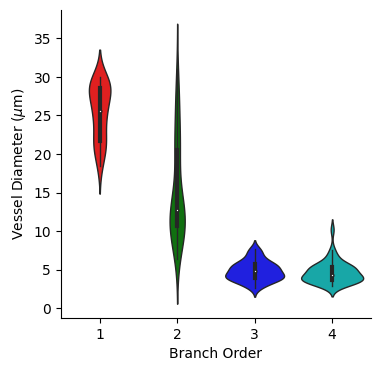

In [8]:
# violin plot of Diameter for each group
fig, ax = plt.subplots(1)
#sns.pointplot(ax=ax, x='Group', y='Length', data=df) # this gives us mean
sns.violinplot(ax=ax, x='group', y='length_um', order=sortedGroups, palette=sortedPallette, data=df)
# this should but does not work, I want to swap x/y
#sns.violinplot(ax=ax, y=df['Group'], x=df['diam'], palette=palette)
ax.set_ylabel('Vessel Diameter ($\mu$m)');
ax.set_xlabel('Branch Order');


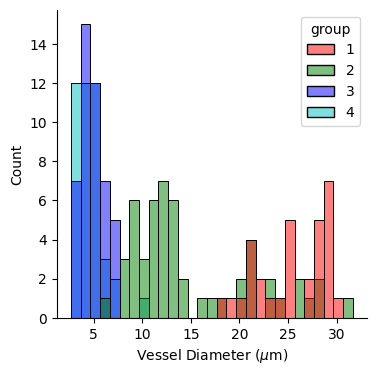

In [9]:
# histogram of Diameter for each group
fig, ax = plt.subplots(1)
binwidth = 1 # um

#sns.histplot(ax=ax, x='diam', hue='Group', binwidth=binwidth, data=df)

sns.histplot(ax=ax, x='length_um', hue='group', binwidth=binwidth,
             hue_order=sortedGroups, palette=sortedPallette,
             data=df)

#g._legend.set_title('Branch Order')
ax.set_xlabel('Vessel Diameter ($\mu$m)')
ax.set_ylabel('Count');


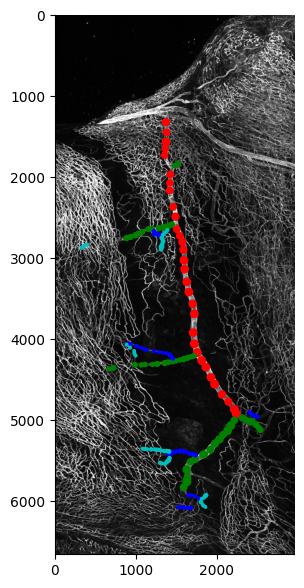

In [10]:
# scatter plot of spatial position, diameter (marker size), and group (color)
fig, ax = plt.subplots(1, figsize=(5,7))

ax.imshow(maxImg, cmap='gray') # 'Reds'

x = df['xMid'].tolist()
y = df['yMid'].tolist()
size = df['length_um'].tolist()

longGroupList = df['group'].tolist()
color = getGroupPallete(longGroupList)

# s specifies, The marker size in points**2. Default is rcParams['lines.markersize'] ** 2.
ax.scatter(x,y, s=size, c=color)
#ax.set_ylim(numRows, 0) #reversed
#ax.set_xlim(0, numCols);
#ax.axis('off')


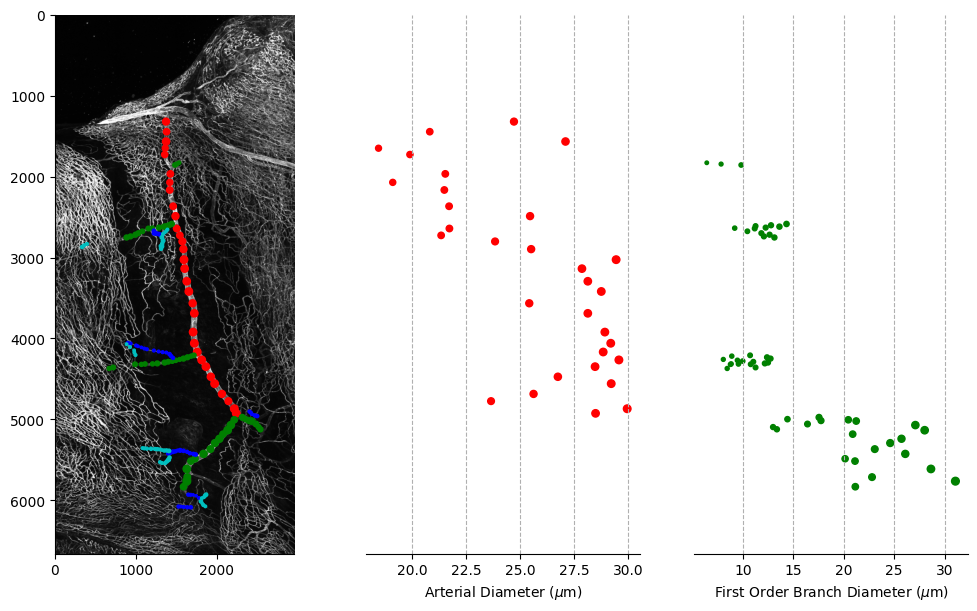

In [11]:
fig, axs = plt.subplots(1,3, figsize=(12,7), sharey=True)

axs[0].imshow(maxImg, cmap='gray') # 'Reds'

# plot diameter measurements over max project
x = df['xMid'].tolist()
y = df['yMid'].tolist()
size = df['length_um'].tolist() #df['size'].tolist()
longGroupList = df['group'].tolist()
color = getGroupPallete(longGroupList)
# s specifies, The marker size in points**2. Default is rcParams['lines.markersize'] ** 2.
axs[0].scatter(x,y, s=size, c=color)
#axs[0].set_ylim(numRows, 0) #reversed
#axs[0].set_xlim(0, numCols)
#axs[0].axis('off')

#
# plot Group 1 length/diam as function of y
theseGroups = [1, 11]
diamGroupOne = df[ df['group'].isin(theseGroups) ]['length_um'].tolist()
yMidGroupOne = df[ df['group'].isin(theseGroups) ]['yMid'].tolist()
size = df[ df['group'].isin(theseGroups) ]['length_um'].tolist()
#color = df[ df['Group'].isin(theseGroups) ]['color'].tolist()
longGroupList = df[ df['group'].isin(theseGroups) ]['group'].tolist()
color = getGroupPallete(longGroupList)

# s specifies, The marker size in points**2. Default is rcParams['lines.markersize'] ** 2.
axs[1].scatter(diamGroupOne, yMidGroupOne, s=size, c=color) #, s=sizeList, c=colorList)
#axs[1].set_ylim(numRows, 0) #reversed
axs[1].grid(which='major', axis='x', linestyle='--')
axs[1].get_yaxis().set_visible(False)
axs[1].spines['left'].set_visible(False);
axs[1].set_xlabel('Arterial Diameter ($\mu$m)');

#
# plot Group 2 length/diam as function of y
theseGroups = [2]
diamGroupOne = df[ df['group'].isin(theseGroups) ]['length_um'].tolist()
yMidGroupOne = df[ df['group'].isin(theseGroups) ]['yMid'].tolist()
size = df[ df['group'].isin(theseGroups) ]['length_um'].tolist()
longGroupList = df[ df['group'].isin(theseGroups) ]['group'].tolist()
color = getGroupPallete(longGroupList)

# s specifies, The marker size in points**2. Default is rcParams['lines.markersize'] ** 2.
axs[2].scatter(diamGroupOne, yMidGroupOne, s=size, c=color) #, s=sizeList, c=colorList)
#axs[2].set_ylim(numRows, 0) #reversed
axs[2].grid(which='major', axis='x', linestyle='--')
axs[2].get_yaxis().set_visible(False)
axs[2].spines['left'].set_visible(False);axs[2].set_xlabel('First Order Branch Diameter ($\mu$m)');


In [12]:
## Back to plotly

In [38]:
import plotly.express as px

# group is int64, for plotly to interpret as disrete values (versus continuous) it has to be a string
df["groupStr"] = df["group"].astype(str)

# 2d
fig = px.scatter(df, x="xMid", y="yMid", color='groupStr', size='length_um')
# 3d
fig = px.scatter_3d(df, x="xMid", y="yMid", z='z', color='groupStr', size='length_um')

fig.show()

In [20]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()


x = df['xMid'].tolist()
y = df['yMid'].tolist()
z = df['z'].tolist()
longGroupList = df['group'].tolist()
color = getGroupPallete(longGroupList)

color = df['group'].tolist()

print(len(x))
print(len(color))

# Configure the trace.
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        'color': color,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

171
171


# Important part: split dataset into superior/inferior

Do this by specifying the range of y pixels (in the image) that corresponds to superior and inferior

Superior diameter (um)


count       mean       std     min     25%     50%       75%     max
Group                                                                      
1       68.0  36.253044  2.489038  32.037  34.484  35.522  37.71825  42.021
2       33.0  16.700333  2.532572  13.051  14.919  15.966  18.47300  24.712
3       32.0  12.142719  1.436860   9.944  11.202  12.089  12.86050  15.195
4       40.0   5.027750  1.022274   3.527   4.320   4.775   5.64575   7.333

Inferior diameter (um)


count       mean       std     min      25%     50%      75%     max
Group                                                                      
1       22.0  27.975227  3.024835  23.353  25.0100  28.599  30.7945  32.092
2       97.0  11.439649  3.553545   4.821   8.0070  12.385  14.8030  17.766
3       63.0   9.520698  2.397148   5.226   6.9700  10.529  11.2765  13.326
4       41.0   5.332195  1.351172   2.989   4.3260   5.241   6.1170   8.565
11      63.0  20.025508  1.968438  16.901  18.3835  19.957  21.3220  25.143

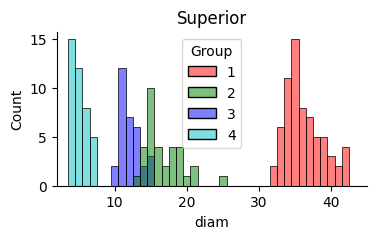

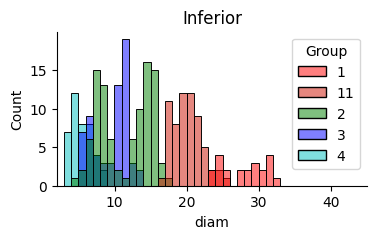

In [29]:
doViolin = False # if False then do hist

# seperate groups into superior/inferior

#
# my SAN4 headMid (we also have 'tail')
ySup = [1000, 3500]
yInf = [4500, 8000]

# fernando san 6
# rows:11840, cols:3700
#ySup = [2000, 6000]
#yInf = [9000,11839]

binwidth = 1 # um
xAxisRange = [2, 45] # manually chosen as max between sup/inf, shared between sup/inf

axs = [np.nan] * 2

#
# superior
theseGroups = [1, 2, 3, 4, 11]

sup_df = df [ (df['yMid']>ySup[0]) & (df['yMid']<ySup[1])]
sup_df = sup_df[ sup_df['Group'].isin(theseGroups) ]

# sort remaining groups
sortedGroups = getSortedGroups(sup_df['Group'].unique())
# get pallette from remaining groups
palette = getGroupPallete(sortedGroups)

desc = sup_df.groupby('Group')['diam'].describe()
print('Superior diameter (um)')
display(desc)

fig, ax = plt.subplots(1,1,figsize=(4,2))
axs[0] = ax

if doViolin:
    sns.violinplot(ax=axs[0], x='Group', y='diam', palette=palette, order=sortedGroups, data=sup_df)
    axs[0].set_ylim(xAxisRange) # share between sup/inf
else:
    sns.histplot(ax=axs[0], x='diam', hue='Group', palette=palette, hue_order=sortedGroups, binwidth=binwidth, data=sup_df)
    axs[0].set_xlim(xAxisRange) # share between sup/inf
axs[0].set_title('Superior');


#
# inferior
theseGroups = [1, 2, 3, 4, 11] # 11 is after primary branched into 2

inf_df = df [ (df['yMid']>yInf[0]) & (df['yMid']<yInf[1])]
inf_df = inf_df[ inf_df['Group'].isin(theseGroups) ]

sortedGroups = getSortedGroups(inf_df['Group'].unique())
# get pallette from remaining groups
palette = getGroupPallete(sortedGroups)

desc = inf_df.groupby('Group')['diam'].describe()
print('Inferior diameter (um)')
display(desc)

fig, ax = plt.subplots(1,1,figsize=(4,2))
axs[1] = ax

if doViolin:
    sns.violinplot(ax=axs[1], x='Group', y='diam', palette=palette, order=sortedGroups, data=inf_df)
    axs[1].set_ylim(xAxisRange) # share between sup/inf
else:
    sns.histplot(ax=axs[1], x='diam', hue='Group', palette=palette, hue_order=sortedGroups, binwidth=binwidth, data=inf_df)
    axs[1].set_xlim(xAxisRange) # share between sup/inf
axs[1].set_title('Inferior');
